This notebook is adapted from [tf tutorials](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)

## Setup

Before getting started, import the necessary packages:

In [5]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard

print(tf.__version__)

2.4.1


In [6]:
#!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [7]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

import re
import time


In [8]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
#shutil.rmtree(logdir, ignore_errors=True)

---------------
# > What is tf.keras?

`tf.keras` is TensorFlow's high-level API for building and training deep learning models. [website](https://keras.io/)

----------------------


#### The Higgs Dataset

The goal of this tutorial is not to do particle physics, so don't dwell on the details of the dataset. It contains 11&#x202F;000&#x202F;000 examples, each with 28 features, and a binary class label.

In [9]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [10]:
FEATURES = 28

The `tf.data.experimental.CsvDataset` class can be used to read csv records directly from a gzip file with no intermediate decompression step.

In [11]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

----------
# > What is tf.data?

The tf.data API makes it possible to handle large amounts of data, read from different data formats, and perform complex transformations.

**Basic mechanics**

To construct a Dataset from data in memory, you can use `tf.data.Dataset.from_tensors()` or `tf.data.Dataset.from_tensor_slices()`.

# >What is a tensor in TF?
If you're familiar with NumPy, tensors are (kind of) like `np.arrays`.

In [12]:
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])

In [13]:
#The Dataset object is a Python iterable. This makes it possible to consume its elements using a for loop:
for ele in dataset:
  print(ele.numpy())

8
3
0
8
2
1


In [14]:
# Once you have a Dataset object, you can transform it into a new Dataset by chaining method calls on the tf.data.Dataset object. 
# For example, you can apply per-element transformations such as Dataset.map().
def fun(x):
    return x * 2

dataset = dataset.map(fun)#.shuffle(buffer_size=6).batch(4).repeat(2)

In [15]:
for i, elem in enumerate(dataset):
  print(i,elem.numpy())

0 16
1 6
2 0
3 16
4 4
5 2


---------

Let's quickly check what is in the ds. The schema of the Higgs dataset is: `label, x1,x2,...x28` and each entry here is a tf.tensor.

In [16]:
for x in ds.take(1):
  print(x)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.8692932>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.6350818>, <tf.Tensor: shape=(), dtype=float32, numpy=0.22569026>, <tf.Tensor: shape=(), dtype=float32, numpy=0.32747006>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.6899932>, <tf.Tensor: shape=(), dtype=float32, numpy=0.75420225>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.24857314>, <tf.Tensor: shape=(), dtype=float32, numpy=-1.0920639>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3749921>, <tf.Tensor: shape=(), dtype=float32, numpy=-0.6536742>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9303491>, <tf.Tensor: shape=(), dtype=float32, numpy=1.1074361>, <tf.Tensor: shape=(), dtype=float32, numpy=1.1389043>, <tf.Tensor: shape=(), dtype=float32, numpy=-1.5781983>, <tf.Tensor: shape=(), dtype=float32, numpy=-1.0469854>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shap

That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [17]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow is most efficient when operating on large batches of data.

So instead of repacking each row individually, we will make a new `Dataset` that takes batches of 10000-examples, applies the `pack_row` function to each batch, and then splits the batches back up into individual records:

In [18]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

Have a look at some of the records from this new `packed_ds`.

The features are not perfectly normalized, but this is sufficient for this tutorial.

In [19]:
for x, y in packed_ds.take(1):
  print(x)

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)
tf.Tensor(
[ 1.2179255  -0.3078283  -1.6015735   1.5323688  -1.0068238   0.55578095
 -0.05943923  0.8195276   2.1730762   0.84002817 -1.4307731   0.5020205
  0.          0.4631135  -0.8008459  -0.21487965  2.5482244   0.40697673
 -1.487883    0.81112     0.          0.6272983   0.812112    0.9893707
  0.70444375  0.5734874   0.7088749   0.7649955 ], shape=(28,), dtype=float32)


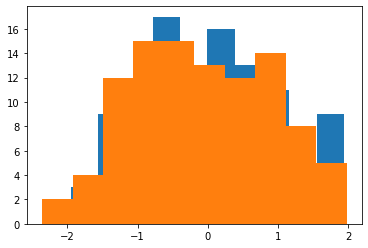

In [20]:
for features,label in packed_ds.batch(100).take(2):
  print(features[0])
  plt.hist(features.numpy()[:,1].flatten())

--------
# > What is batch, epoch and iteration in Machine Learning?
We need terminologies like epochs, batch size, iterations only when the data is too big which happens all the time in machine learning and **we can’t pass all the data to the computer at once**. So, to overcome this problem we need to divide the data into smaller sizes and give it to our computer one by one and update the weights of the neural networks at the end of every step to fit it to the data given.
![alt text](https://desireai.com/wp-content/uploads/2019/08/difference-between-batch_size-and-epochs-300x258.png)

## Epoch:
One Epoch is when an **ENTIRE dataset** is passed forward and backward through the neural network only ONCE.

## Batch size:
Total number of training examples present in a single batch.

## Iteration:
Iterations is the number of batches needed to complete one epoch.

## Example:
Suppose you have 1,000 data sample and you have specified a batch size with 100 
data sample. You will have 10 weight update for each epoch.

*We always train with multiple epochs. Because passing the entire dataset through a neural network once is not enough. And we need to pass the full dataset multiple times to the same neural network.*

-------

To keep this tutorial relatively short use just the first 1,000 samples for validation, and the next 10,000 for training:

In [21]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

The `Dataset.skip` and `Dataset.take` methods make this easy.

At the same time, use the `Dataset.cache` method to ensure that the loader doesn't need to re-read the data from the file on each epoch:

In [22]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [23]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

These datasets return individual examples. Use the `.batch` method to create batches of an appropriate size for training. Before batching also remember to `.shuffle` and `.repeat` the training set.

In [24]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

### Tiny model

1. Start by defining a model:

In [21]:
model = tf.keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

`tf.keras.Sequential` groups a linear stack of layers into a tf.keras.Model.
`A linear stack is a model` without any branching. Every layer has one input and output. The output of one layer is the input of the layer below it.

2. Choose an optimizer and loss function for training

In [22]:
optimizer = tf.keras.optimizers.Adam()

`Optimizer` is optimization method. Commonly used optimizers are Adam, SGD. Please check the details [here](https://ruder.io/optimizing-gradient-descent/)

In [23]:
loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=True)

`BinaryCrossentropy` computes the cross-entropy loss between true labels and predicted labels. Check the explanation [here](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)

Let's see an example here:

In [24]:
y_true = [[0., 1.], [0., 1.]]
y_pred = [[0.6, 0.4], [0.4, 0.6]]

bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred).numpy()


0.71355796

3. Let's compile and fit the model

In [25]:
model.compile(optimizer=optimizer,
              loss=loss_func,
              metrics=[
                tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),
                'accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [27]:
epochs = 1000
history = model.fit(
          train_ds,
          steps_per_epoch = STEPS_PER_EPOCH,
          epochs=epochs,
          validation_data=validate_ds,
          callbacks = [tf.keras.callbacks.TensorBoard(log_dir="./logs"),
                       tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200)],
          verbose = 0
          )

 `callbacks.EarlyStopping` to end the training once it was clear the model was not making progress.

 `callbacks.TensorBoard` to generate TensorBoard logs for the training.


### View in TensorBoard

These models all wrote TensorBoard logs during training.

Open an embedded  TensorBoard viewer inside a notebook:

In [24]:
%load_ext tensorboard
%tensorboard --logdir "./logs"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 24400), started 3 days, 4:46:25 ago. (Use '!kill 24400' to kill it.)

$\Omega$ Practice time: can you beat the performance of the tiny model?
Hints:
1. Build a deeper and wider network
2. Try different activation functions (e.g. Sigmoid, leaky relu, elu) and optimizers
3. Add weight regularization and dropout in case of overfitting

![separator2](https://i.imgur.com/4gX5WFr.png)

## Big Model

In [63]:
%load_ext tensorboard

In [25]:
FEATURES

28

In [53]:
# Function to remove all non alphanumeric and non-underscore characters from the string.
def re_func(your_string):
    return(re.sub(r'\W+', '', your_string))

# Function to extract the name of hyperparameter from a tensorflow deep learning hyperparameter choice.
def tf_hyper_name(tf_hyper_para):
    name = [re_func(element) for element in str(tf_hyper_para).split(".") ][-1]
    
    if 'object' in name:
        name = name.split('object')[0]
    name = name.strip()
    return(name)
    
    

In [54]:
optimizer = tf.keras.optimizers.Adam
tf_hyper_name(optimizer)
print(optimizer)
print(str(optimizer))
print("  ")
print(str(optimizer).split("."))
clean_str_list = [re_func(element) for element in str(optimizer).split(".") ]
print(clean_str_list)

<class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>
<class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>
  
["<class 'tensorflow", 'python', 'keras', 'optimizer_v2', 'adam', "Adam'>"]
['classtensorflow', 'python', 'keras', 'optimizer_v2', 'adam', 'Adam']


## Hyperparameter selection

In [68]:
optimizer = tf.keras.optimizers.Adam
opt_name = tf_hyper_name(optimizer)
print(opt_name)
loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=True)
print(str(loss_func).split('.'))
loss_name = tf_hyper_name(loss_func)
print(loss_name)

num_hidden_neurons = 20
activation='relu'
epochs = 1000
batch_size = 'notspecified'
STEPS_PER_EPOCH = 20
print(STEPS_PER_EPOCH)
print(num_hidden_neurons)

MODEL_NAME = "dnn4hl_hn_{}_opt_{}_loss_{}_acti_{}_epochs_{}_batchsi_{}_{}".format(num_hidden_neurons, 
                                                                            opt_name,
                                                                            loss_name,
                                                                            activation,
                                                                            epochs,
                                                                            batch_size,
                                                                            int(time.time()) )
print(MODEL_NAME)

Adam
['<tensorflow', 'python', 'keras', 'losses', 'BinaryCrossentropy object at 0x00000157151F79D0>']
BinaryCrossentropy
20
20
dnn4hl_hn_20_opt_Adam_loss_BinaryCrossentropy_acti_relu_epochs_1000_batchsi_notspecified_1623120828


In [72]:
#model.compile?

In [70]:

model = tf.keras.Sequential([
    layers.Dense(num_hidden_neurons, activation=activation, input_shape=(FEATURES,)),
    layers.Dense(num_hidden_neurons, activation = activation),
    layers.Dense(num_hidden_neurons, activation = activation),
    layers.Dense(num_hidden_neurons, activation = activation),
    layers.Dense(1)
])

y_true = [[0., 1.], [0., 1.]]
y_pred = [[0.6, 0.4], [0.4, 0.6]]

                                                                                
tb = TensorBoard(log_dir='logs/{}'.format(MODEL_NAME))
es =  tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200)
bce = tf.keras.losses.BinaryCrossentropy()

print(bce(y_true, y_pred).numpy())

model.compile(optimizer=opt_name, loss=loss_func,
              metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),
                'accuracy'])
print(model.summary())

history = model.fit(
          train_ds,
          steps_per_epoch = STEPS_PER_EPOCH,
          epochs=epochs,
          validation_data=validate_ds,
          callbacks = [tb, es ],
          verbose = 0
          )

0.71355796
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 20)                580       
_________________________________________________________________
dense_26 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_27 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_28 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 21        
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
_________________________________________________________________
None


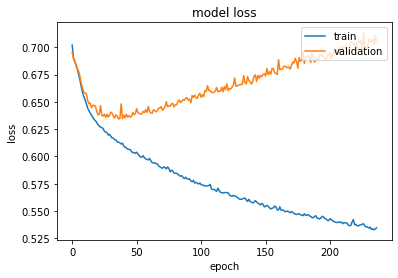

In [71]:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

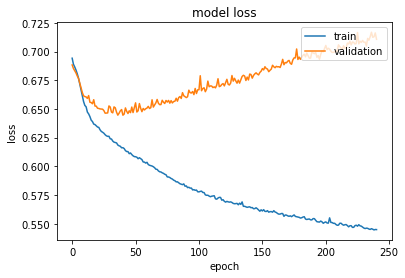

In [61]:
# 4 hidden layers with 16 hidden neuron per layer. 
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [33]:
history

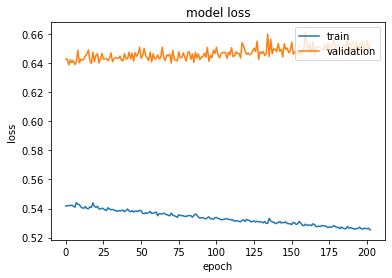

In [34]:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [67]:
%tensorboard --logdir "./logs"

Reusing TensorBoard on port 6006 (pid 24400), started 3 days, 21:14:15 ago. (Use '!kill 24400' to kill it.)